In [1]:
from functools import partial
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant, safe_logodds
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer, MCDropoutKerasClassification

2022-05-10 13:19:31.985357: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-10 13:19:31.985384: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#def generate_chisq_chisq_data(num_train=100000, num_val=20000, noise_level=0.):
num_train=100096
num_val=20000
noise_level=0.01
# generate some data
s = partial(map_to_constant, c=noise_level)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="cauchy", threshold=0.5,
                                  noise_distribution="cauchy", noise_scale=s)
x, y = eg.generate_labeled(num_train + num_val)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:num_train, :], y[:num_train]
x_val, y_val = x[num_train:, :], y[num_train:]
#return x_train, y_train, x_val, y_val

In [3]:
layers = (
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(1, activation="sigmoid")
)
mcd_classifier = MCDropoutKerasClassification(
    layer_tuple=layers,
    optimizer=keras.optimizers.Adamax(learning_rate=0.0056),
    loss="binary_crossentropy",
    metrics=("accuracy", "AUC"),
    name="MCDropout"
)
mcd_classifier.fit(
    x_train,
    y_train,
    epochs=3,
    batch_size=8,
    validation_data=(x_val, y_val)
)

Epoch 1/3


2022-05-10 13:19:34.288327: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-10 13:19:34.288368: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-10 13:19:34.288393: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-05-10 13:19:34.288627: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


12512/12512 [==============================] - 17s 1ms/step - loss: 0.1829 - accuracy: 0.9265 - auc: 0.9797 - val_loss: 0.1047 - val_accuracy: 0.9637 - val_auc: 0.9919
Epoch 2/3
12512/12512 [==============================] - 16s 1ms/step - loss: 0.0951 - accuracy: 0.9693 - auc: 0.9929 - val_loss: 0.0805 - val_accuracy: 0.9757 - val_auc: 0.9939
Epoch 3/3
12512/12512 [==============================] - 16s 1ms/step - loss: 0.0837 - accuracy: 0.9741 - auc: 0.9938 - val_loss: 0.0874 - val_accuracy: 0.9725 - val_auc: 0.9934


In [4]:
# compute, sort, and smooth all quantities to plot
n = 1  # smoothing window for convolutions in plots
s = 300  # number of samples to use in mean and percentile estimates
post_lo_mean = mcd_classifier.posterior_mean_logodds(x_val[:100, :], n=s)

p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
ptiles = mcd_classifier.posterior_percentile_proba(x_val[:100, :], n=s, q=(5, 95), axis=0)
p_l = ptiles[0, :, 0]
p_h = ptiles[1, :, 0]

scores = eg.get_scores(x_val[:100,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:100,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_l = np.convolve(p_l[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_h = np.convolve(p_h[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

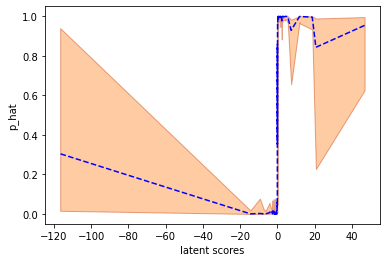

In [5]:
plt.plot(scores, p, '--b')
plt.fill_between(scores, p_l, p_h, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

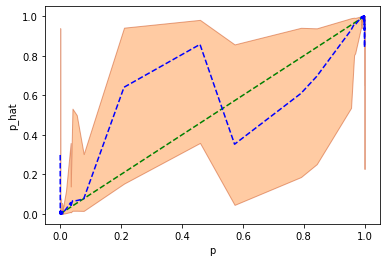

In [6]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.fill_between(probs, p_l, p_h, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

In [7]:
# find percentage of 95% confidence intervals containing the true probability
s = 300  # number of posterior samples to sample for posterior for each x
d = 10000  # number of x samples points to use

post_lo_mean = mcd_classifier.posterior_mean_logodds(x_val[:d, :], n=s)
p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
ptiles = mcd_classifier.posterior_percentile_proba(x_val[:d, :], n=s, q=(5, 95), axis=0)
p_l = ptiles[0, :, 0]
p_h = ptiles[1, :, 0]

probs = eg.get_probabilities(x_val[:d,:])[1]
logodds = safe_logodds(probs)

2022-05-10 13:20:24.865965: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 120000000 exceeds 10% of free system memory.
2022-05-10 13:21:37.028682: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 120000000 exceeds 10% of free system memory.


For noise level: 0.01: 82.69% within 90% CI


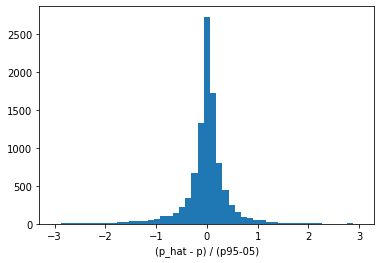

In [8]:
inside = np.logical_and(np.less_equal(p_l, probs), np.less_equal(probs, p_h))
print ("For noise level: 0.01: {}% within 90% CI".format(100*np.mean(inside)))

normed_p_dist = (p - probs) /(1e-16 + p_h - p_l)
bins = np.linspace(-3,3)
plt.hist(normed_p_dist, bins=bins)
plt.xlabel('(p_hat - p) / (p95-05)')
plt.show()

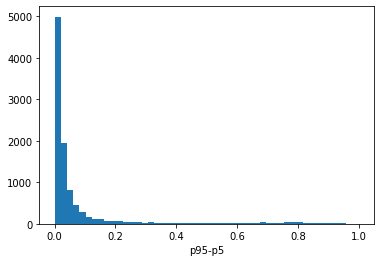

In [9]:
bins = np.linspace(0.,1.)
plt.hist(p_h - p_l, bins=bins)
plt.xlabel('p95-p5')
plt.show()

In [10]:
#def generate_chisq_chisq_data(num_train=100000, num_val=20000, noise_level=0.):
num_train=100096
num_val=20000
noise_level=0.1
# generate some data
s = partial(map_to_constant, c=noise_level)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="cauchy", threshold=0.5,
                                  noise_distribution="cauchy", noise_scale=s)
x, y = eg.generate_labeled(num_train + num_val)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:num_train, :], y[:num_train]
x_val, y_val = x[num_train:, :], y[num_train:]
#return x_train, y_train, x_val, y_val

In [11]:
layers = (
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(1, activation="sigmoid")
)
mcd_classifier = MCDropoutKerasClassification(
    layer_tuple=layers,
    optimizer=keras.optimizers.Adamax(learning_rate=0.0084),
    loss="binary_crossentropy",
    metrics=("accuracy", "AUC"),
    name="MCDropout"
)
mcd_classifier.fit(
    x_train,
    y_train,
    epochs=3,
    batch_size=8,
    validation_data=(x_val, y_val)
)

Epoch 1/3
12512/12512 [==============================] - 16s 1ms/step - loss: 0.3026 - accuracy: 0.8832 - auc: 0.9441 - val_loss: 0.2559 - val_accuracy: 0.9083 - val_auc: 0.9571
Epoch 2/3
12512/12512 [==============================] - 15s 1ms/step - loss: 0.2452 - accuracy: 0.9131 - auc: 0.9605 - val_loss: 0.2447 - val_accuracy: 0.9172 - val_auc: 0.9605
Epoch 3/3
12512/12512 [==============================] - 14s 1ms/step - loss: 0.2385 - accuracy: 0.9171 - auc: 0.9622 - val_loss: 0.2419 - val_accuracy: 0.9164 - val_auc: 0.9612


In [12]:
# compute, sort, and smooth all quantities to plot
n = 1  # smoothing window for convolutions in plots
s = 300  # number of samples to use in mean and percentile estimates
post_lo_mean = mcd_classifier.posterior_mean_logodds(x_val[:100, :], n=s)

p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
ptiles = mcd_classifier.posterior_percentile_proba(x_val[:100, :], n=s, q=(5, 95), axis=0)
p_l = ptiles[0, :, 0]
p_h = ptiles[1, :, 0]

scores = eg.get_scores(x_val[:100,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:100,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_l = np.convolve(p_l[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_h = np.convolve(p_h[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

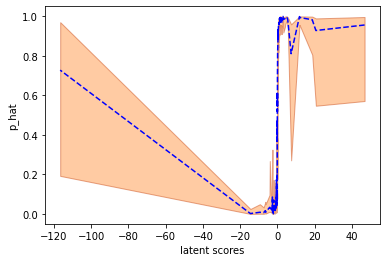

In [13]:
plt.plot(scores, p, '--b')
plt.fill_between(scores, p_l, p_h, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

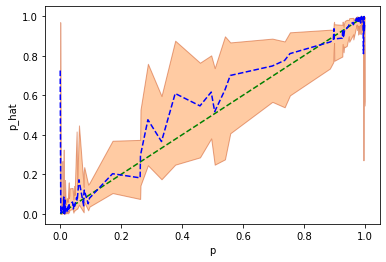

In [14]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.fill_between(probs, p_l, p_h, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

In [15]:
# find percentage of 95% confidence intervals containing the true probability
s = 300  # number of posterior samples to sample for posterior for each x
d = 10000  # number of x samples points to use

post_lo_mean = mcd_classifier.posterior_mean_logodds(x_val[:d, :], n=s)
p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
ptiles = mcd_classifier.posterior_percentile_proba(x_val[:d, :], n=s, q=(5, 95), axis=0)
p_l = ptiles[0, :, 0]
p_h = ptiles[1, :, 0]

probs = eg.get_probabilities(x_val[:d,:])[1]
logodds = safe_logodds(probs)

2022-05-10 13:23:37.778754: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 120000000 exceeds 10% of free system memory.
2022-05-10 13:24:54.918774: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 120000000 exceeds 10% of free system memory.


For noise level: 0.1: 91.7% within 90% CI


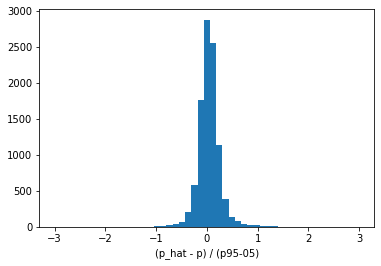

In [16]:
inside = np.logical_and(np.less_equal(p_l, probs), np.less_equal(probs, p_h))
print ("For noise level: 0.1: {}% within 90% CI".format(100*np.mean(inside)))

normed_p_dist = (p - probs) /(1e-16 + p_h - p_l)
plt.hist(normed_p_dist, bins=np.linspace(-3,3))
plt.xlabel('(p_hat - p) / (p95-05)')
plt.show()

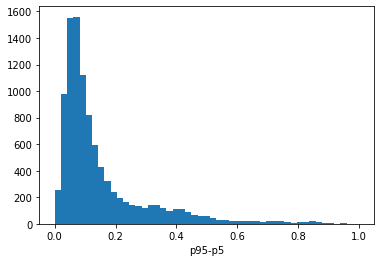

In [17]:
plt.hist(p_h - p_l, bins=np.linspace(0.,1.))
plt.xlabel('p95-p5')
plt.show()

In [18]:
#def generate_chisq_chisq_data(num_train=100000, num_val=20000, noise_level=0.):
num_train=100096
num_val=20000
noise_level=0.3
# generate some data
s = partial(map_to_constant, c=noise_level)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="cauchy", threshold=0.5,
                                  noise_distribution="cauchy", noise_scale=s)
x, y = eg.generate_labeled(num_train + num_val)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:num_train, :], y[:num_train]
x_val, y_val = x[num_train:, :], y[num_train:]
#return x_train, y_train, x_val, y_val

In [19]:
layers = (
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(1, activation="sigmoid")
)
mcd_classifier = MCDropoutKerasClassification(
    layer_tuple=layers,
    optimizer=keras.optimizers.Adamax(learning_rate=0.0056),
    loss="binary_crossentropy",
    metrics=("accuracy", "AUC"),
    name="MCDropout"
)
mcd_classifier.fit(
    x_train,
    y_train,
    epochs=3,
    batch_size=8,
    validation_data=(x_val, y_val)
)

Epoch 1/3
12512/12512 [==============================] - 17s 1ms/step - loss: 0.4405 - accuracy: 0.8082 - auc: 0.8803 - val_loss: 0.3880 - val_accuracy: 0.8414 - val_auc: 0.9071
Epoch 2/3
12512/12512 [==============================] - 17s 1ms/step - loss: 0.3818 - accuracy: 0.8430 - auc: 0.9096 - val_loss: 0.3694 - val_accuracy: 0.8492 - val_auc: 0.9158
Epoch 3/3
12512/12512 [==============================] - 16s 1ms/step - loss: 0.3727 - accuracy: 0.8480 - auc: 0.9137 - val_loss: 0.3695 - val_accuracy: 0.8492 - val_auc: 0.9161


In [20]:
# compute, sort, and smooth all quantities to plot
n = 1  # smoothing window for convolutions in plots
s = 300  # number of samples to use in mean and percentile estimates
post_lo_mean = mcd_classifier.posterior_mean_logodds(x_val[:100, :], n=s)

p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
ptiles = mcd_classifier.posterior_percentile_proba(x_val[:100, :], n=s, q=(5, 95), axis=0)
p_l = ptiles[0, :, 0]
p_h = ptiles[1, :, 0]

scores = eg.get_scores(x_val[:100,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:100,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_l = np.convolve(p_l[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_h = np.convolve(p_h[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

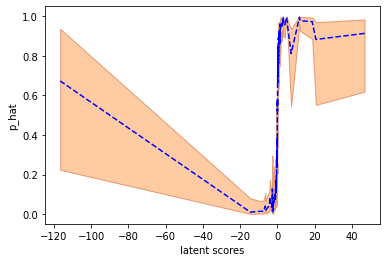

In [21]:
plt.plot(scores, p, '--b')
plt.fill_between(scores, p_l, p_h, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

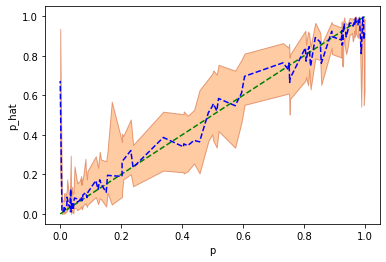

In [22]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.fill_between(probs, p_l, p_h, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

In [23]:
# find percentage of 95% confidence intervals containing the true probability
s = 300  # number of posterior samples to sample for posterior for each x
d = 10000  # number of x samples points to use

post_lo_mean = mcd_classifier.posterior_mean_logodds(x_val[:d, :], n=s)
p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
ptiles = mcd_classifier.posterior_percentile_proba(x_val[:d, :], n=s, q=(5, 95), axis=0)
p_l = ptiles[0, :, 0]
p_h = ptiles[1, :, 0]

probs = eg.get_probabilities(x_val[:d,:])[1]
logodds = safe_logodds(probs)

2022-05-10 13:27:04.039276: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 120000000 exceeds 10% of free system memory.


For noise level: 0.3: 90.27% within 90% CI


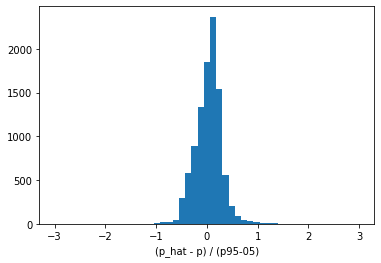

In [24]:
inside = np.logical_and(np.less_equal(p_l, probs), np.less_equal(probs, p_h))
print ("For noise level: 0.3: {}% within 90% CI".format(100*np.mean(inside)))

normed_p_dist = (p - probs) /(1e-16 + p_h - p_l)
plt.hist(normed_p_dist, bins=np.linspace(-3,3))
plt.xlabel('(p_hat - p) / (p95-05)')
plt.show()

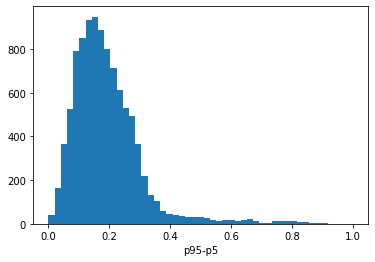

In [25]:
plt.hist(p_h - p_l, bins=np.linspace(0.,1.))
plt.xlabel('p95-p5')
plt.show()